Loading dependencies...
Locating shapefiles...
Reading shapefiles...


/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/pandas/core/computation/expr.py:647: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  v = getattr(resolved, attr)


Identifying parks within the path of totality...
Generating plot...


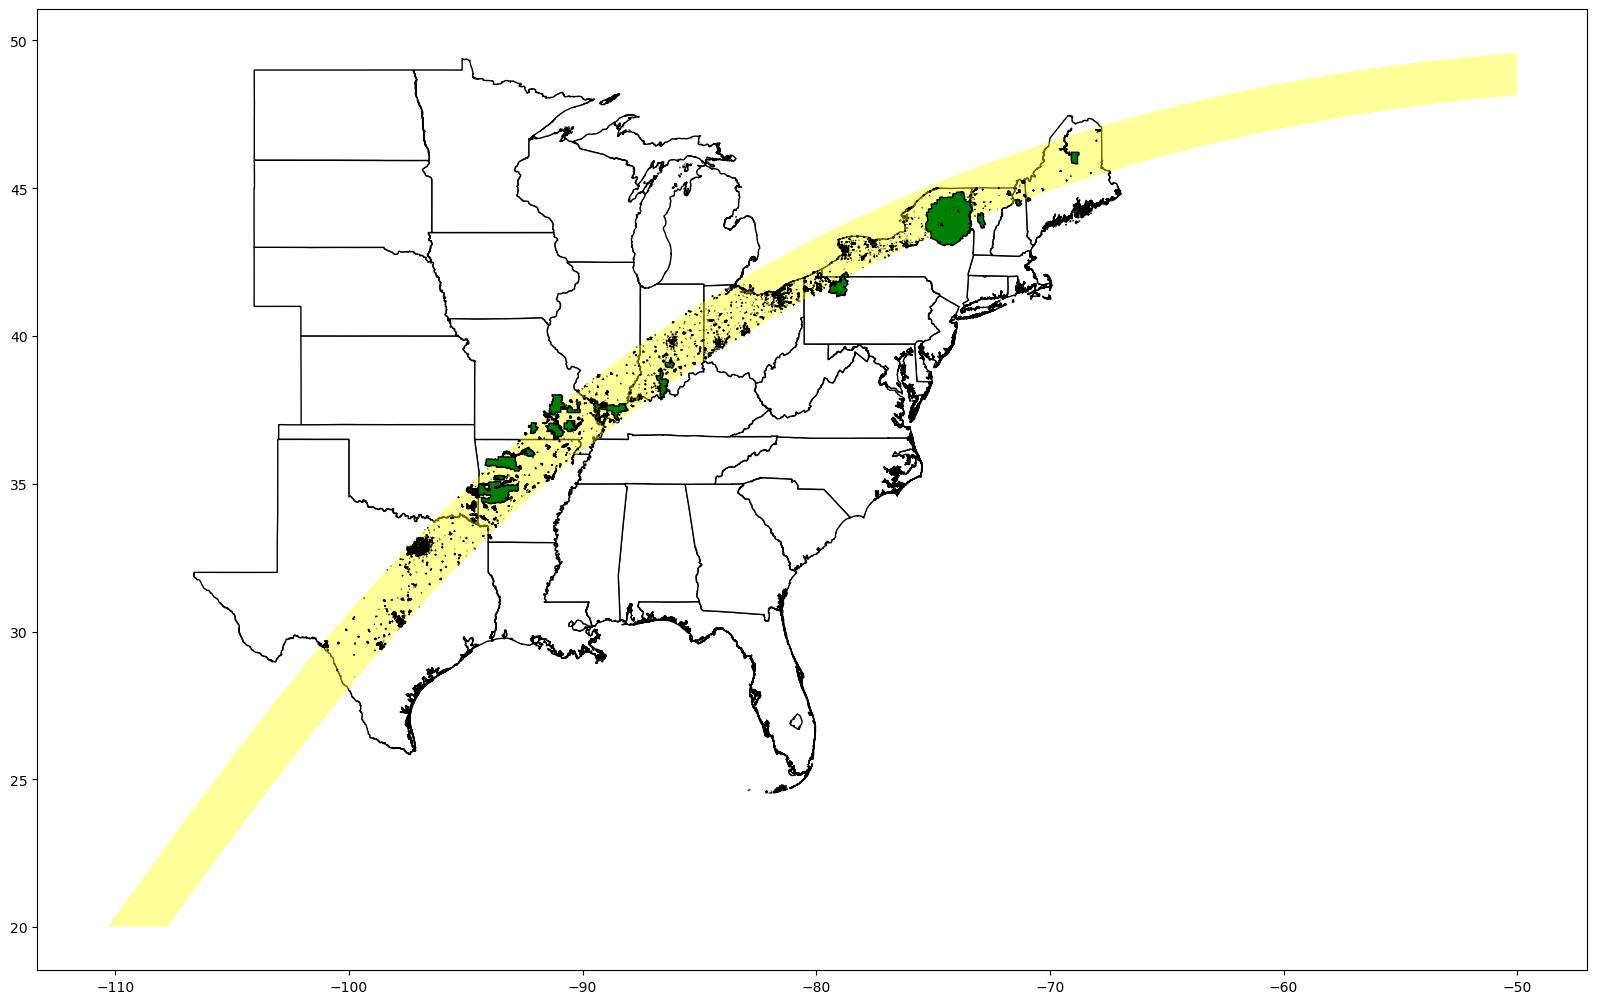

In [1]:
print('Loading dependencies...')
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon

print('Locating shapefiles...')
root = Path('.').resolve()
parks_path =  root / 'park_shapes' / 'united-states-parks.shp'
path_path = root / 'eclipse_shapes'/'upath_hi.dbf'
states_path = root /'state_shapes'/'s_08mr23.shp'


# Load shape files
print('Reading shapefiles...')
parks = gpd.read_file(parks_path.as_posix()).to_crs(4326).query('geometry.centroid.y < 50 and geometry.centroid.x > -140 and geometry.centroid.x < -60')
path = gpd.read_file(path_path.as_posix()).to_crs(4326)
states = gpd.read_file(states_path.as_posix()).to_crs(4326).query('LON < -65 and LON > -105 and LAT > 20 and LAT < 50')

# Find parks that intersect with the path of totality
print('Identifying parks within the path of totality...')
intersections = parks.geometry.intersects(path.geometry[0])
eclipse_parks = parks.assign(intersects=intersections).query('intersects == True')

def filter_polygons(x):
    if x.geom_type == 'MultiPolygon':
        polygons = [y for y in list(x.geoms) if y.intersects(path.geometry[0])]
        if len(polygons) == 1:
            return polygons[0]
        else:
            return MultiPolygon(polygons)
    else:
        return x
    
def find_state(x):

    for idx, row in states.iterrows():
        if x.intersects(row.geometry):
            return row.NAME

eclipse_parks = eclipse_parks.assign(
    geometry=eclipse_parks.geometry.apply(filter_polygons),
    state=eclipse_parks.geometry.apply(find_state))

fig, ax = plt.subplots(figsize=(20, 15))
print('Generating plot...')
states.geometry.plot(color='white', edgecolor='black', ax=ax)
path.geometry.plot(color='yellow', alpha=.4, ax=ax)
eclipse_parks.geometry.plot(color='green', edgecolor='black', ax=ax);

In [23]:
eclipse_states = states.assign(intersection=states.geometry.intersection(path.geometry[0]).centroid,
              latitude=lambda x: x['intersection'].y).query('~intersection.is_empty').sort_values('latitude').reset_index(drop=True)

/var/folders/2f/tpt217950yq04pn0x8wyybc80000gp/T/ipykernel_5949/1247865928.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  eclipse_states = states.assign(intersection=states.geometry.intersection(path.geometry[0]).centroid,


In [35]:
eclipse_states

,STATE,NAME,FIPS,LON,LAT,geometry,intersection,latitude
0,TX,Texas,48,-99.35939,31.49422,"MULTIPOLYGON (((-97.19970 25.99932, -97.19998 ...",POINT (-97.77116 31.28981),31.289811
1,OK,Oklahoma,40,-97.50819,35.58345,"POLYGON ((-100.08950 37.00231, -100.05299 37.0...",POINT (-95.04869 34.29553),34.295529
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",POINT (-92.67621 35.23261),35.232608
3,TN,Tennessee,47,-86.34332,35.84299,"POLYGON ((-88.04480 36.67801, -88.02460 36.677...",POINT (-89.50477 36.45909),36.459089
4,MO,Missouri,29,-92.38554,38.32080,"POLYGON ((-91.72970 40.61361, -91.72010 40.601...",POINT (-90.55830 37.03865),37.038647
5,KY,Kentucky,21,-85.29046,37.52668,"MULTIPOLYGON (((-89.48360 36.50021, -89.48499 ...",POINT (-88.28721 37.36235),37.362345
6,IL,Illinois,17,-89.19838,40.06501,"POLYGON ((-90.64000 42.50841, -90.63660 42.508...",POINT (-88.68322 38.26746),38.267458
7,IN,Indiana,18,-86.27548,39.90801,"POLYGON ((-86.08849 41.76071, -86.06750 41.760...",POINT (-86.24562 39.38921),39.389207
8,OH,Ohio,39,-82.79002,40.29120,"MULTIPOLYGON (((-82.65704 41.43713, -82.65740 ...",POINT (-83.09949 40.78689),40.786891
9,MI,Michigan,26,-85.43675,44.34717,"MULTIPOLYGON (((-83.43458 41.73714, -83.43464 ...",POINT (-83.50163 41.76350),41.763498


In [47]:
from pyproj import Geod
from shapely import Point

geod = Geod(ellps="WGS84")

cities = gpd.pd.DataFrame(cities_eclipse_2024).assign(totality=lambda x: x.apply(lambda y: path.geometry[0].intersects(Point(y.LON, y.LAT)), axis=1)).query('totality==True')


In [65]:
size_ = geod.geometry_area_perimeter
size = lambda x: round(abs(size_(x)[0] / 2_589_988.11))
eclipse_states = eclipse_states.assign(
    total_size=lambda x: x.geometry.apply(lambda y: size(y)),
    path_intersection=lambda x: x.geometry.intersection(path.geometry[0]),
    path_size=lambda x: x.path_intersection.apply(lambda y: size(y)),
    percent_path=lambda x: (x.path_size / x.total_size).apply(lambda y: '{:.2%}'.format(y)))

,STATE,NAME,FIPS,LON,LAT,geometry,intersection,latitude,total_size,path_size,percent_path,path_intersection
0,TX,Texas,48,-99.35939,31.49422,"MULTIPOLYGON (((-97.19970 25.99932, -97.19998 ...",POINT (-97.77116 31.28981),31.289811,264726,57036,21.55%,"MULTIPOLYGON (((-94.07090 33.57741, -94.07420 ..."
1,OK,Oklahoma,40,-97.50819,35.58345,"POLYGON ((-100.08950 37.00231, -100.05299 37.0...",POINT (-95.04869 34.29553),34.295529,69901,5139,7.35%,"POLYGON ((-94.43750 35.24251, -94.43780 35.239..."
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",POINT (-92.67621 35.23261),35.232608,53179,28426,53.45%,"POLYGON ((-91.62849 36.49921, -91.61770 36.499..."
3,TN,Tennessee,47,-86.34332,35.84299,"POLYGON ((-88.04480 36.67801, -88.02460 36.677...",POINT (-89.50477 36.45909),36.459089,42144,14,0.03%,"MULTIPOLYGON (((-89.53889 36.41641, -89.54230 ..."
4,MO,Missouri,29,-92.38554,38.32080,"POLYGON ((-91.72970 40.61361, -91.72010 40.601...",POINT (-90.55830 37.03865),37.038647,69704,13037,18.70%,"POLYGON ((-90.24310 38.11271, -90.21870 38.094..."
5,KY,Kentucky,21,-85.29046,37.52668,"MULTIPOLYGON (((-89.48360 36.50021, -89.48499 ...",POINT (-88.28721 37.36235),37.362345,40409,2185,5.41%,"MULTIPOLYGON (((-89.48499 36.49781, -89.49250 ..."
6,IL,Illinois,17,-89.19838,40.06501,"POLYGON ((-90.64000 42.50841, -90.63660 42.508...",POINT (-88.68322 38.26746),38.267458,56340,13088,23.23%,"POLYGON ((-87.53290 39.71301, -87.53280 39.707..."
7,IN,Indiana,18,-86.27548,39.90801,"POLYGON ((-86.08849 41.76071, -86.06750 41.760...",POINT (-86.24562 39.38921),39.389207,36182,21217,58.64%,"POLYGON ((-84.80370 41.14731, -84.80379 41.140..."
8,OH,Ohio,39,-82.79002,40.29120,"MULTIPOLYGON (((-82.65704 41.43713, -82.65740 ...",POINT (-83.09949 40.78689),40.786891,41253,20792,50.40%,"MULTIPOLYGON (((-82.65740 41.43713, -82.65789 ..."
9,MI,Michigan,26,-85.43675,44.34717,"MULTIPOLYGON (((-83.43458 41.73714, -83.43464 ...",POINT (-83.50163 41.76350),41.763498,58169,27,0.05%,"MULTIPOLYGON (((-83.43464 41.73713, -83.43486 ..."


In [44]:
abs(geod.geometry_area_perimeter(eclipse_states.geometry[1].intersection(path.geometry[0]))[0]) / 

5138.571700721745

In [45]:
abs(geod.geometry_area_perimeter(eclipse_states.geometry[1])[0]) / 2_589_988.11

69900.74494875326

In [46]:
eclipse_states

,STATE,NAME,FIPS,LON,LAT,geometry,intersection,latitude
0,TX,Texas,48,-99.35939,31.49422,"MULTIPOLYGON (((-97.19970 25.99932, -97.19998 ...",POINT (-97.77116 31.28981),31.289811
1,OK,Oklahoma,40,-97.50819,35.58345,"POLYGON ((-100.08950 37.00231, -100.05299 37.0...",POINT (-95.04869 34.29553),34.295529
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",POINT (-92.67621 35.23261),35.232608
3,TN,Tennessee,47,-86.34332,35.84299,"POLYGON ((-88.04480 36.67801, -88.02460 36.677...",POINT (-89.50477 36.45909),36.459089
4,MO,Missouri,29,-92.38554,38.32080,"POLYGON ((-91.72970 40.61361, -91.72010 40.601...",POINT (-90.55830 37.03865),37.038647
5,KY,Kentucky,21,-85.29046,37.52668,"MULTIPOLYGON (((-89.48360 36.50021, -89.48499 ...",POINT (-88.28721 37.36235),37.362345
6,IL,Illinois,17,-89.19838,40.06501,"POLYGON ((-90.64000 42.50841, -90.63660 42.508...",POINT (-88.68322 38.26746),38.267458
7,IN,Indiana,18,-86.27548,39.90801,"POLYGON ((-86.08849 41.76071, -86.06750 41.760...",POINT (-86.24562 39.38921),39.389207
8,OH,Ohio,39,-82.79002,40.29120,"MULTIPOLYGON (((-82.65704 41.43713, -82.65740 ...",POINT (-83.09949 40.78689),40.786891
9,MI,Michigan,26,-85.43675,44.34717,"MULTIPOLYGON (((-83.43458 41.73714, -83.43464 ...",POINT (-83.50163 41.76350),41.763498


# Generate GeoJson

### Adding tooltip data to parks dataset

In [2]:
from scipy import spatial
from datetime import datetime
from requests import get
import pytz
from tqdm import tqdm
from timezonefinder import TimezoneFinder

# Calculate park coordinates
eclipse_parks = eclipse_parks.assign(
    x=lambda y: y.geometry.centroid.apply(lambda z: z.x),
    y=lambda x: x.geometry.centroid.apply(lambda z: z.y)
    )

# Collect city eclipse data
cities_eclipse_2024 = get('https://svs.gsfc.nasa.gov/vis/a000000/a005000/a005073/cities-eclipse-2024.json').json()

# Each city coordinate will be compared to park coordinates
city_coordinates = [(x['LAT'], x['LON']) for x in cities_eclipse_2024]
park_coordinates = [(row.y, row.x) for idx, row in eclipse_parks.iterrows()]


# Distance calculator
tree = spatial.KDTree(city_coordinates)

nearest_cities = []
city_gmaps_links = []
park_gmaps_links = []
park_times = []
for coor in tqdm(park_coordinates):
    # Find nearest city
    distance, city_idx = tree.query(coor)
    city = cities_eclipse_2024[city_idx]
    nearest_city = f'{city["NAME"]}, {city["STATE"]}'

    # Generate google maps urls for the city and the park
    city_gmaps_link =f'http://maps.google.com/?ll={city["LAT"]},{city["LON"]}'
    park_gmaps_link = f'http://maps.google.com/?ll={coor[0]},{coor[1]}'

    # Get starting timestamp for eclipse
    eclipse_time_utc_start = city['ECLIPSE'][0]
    eclipse_time_utc_end = city['ECLIPSE'][-1]
    city_coors = (int(city["LAT"]), int(city["LON"]))

    tf = TimezoneFinder()
    timezone_name = tf.timezone_at(lat=coor[0], lng=coor[1])
    timezone = pytz.timezone(timezone_name)

    utc_time_start = datetime.strptime(eclipse_time_utc_start + ' ' + 'UTC', '%H:%M:%S %Z')
    local_time_start = pytz.utc.localize(utc_time_start, is_dst=None).astimezone(timezone)

    utc_time_end = datetime.strptime(eclipse_time_utc_end + ' ' + 'UTC', '%H:%M:%S %Z')
    local_time_end = pytz.utc.localize(utc_time_end, is_dst=None).astimezone(timezone)

    local_time_str = (
        local_time_start.strftime('%I:%M %p') 
        + '-' 
        + local_time_end.strftime('%I:%M %p') 
        + ' '
        + timezone_name
        )

    nearest_cities.append(nearest_city)
    city_gmaps_links.append(city_gmaps_link)
    park_gmaps_links.append(park_gmaps_link)
    park_times.append(local_time_str)

eclipse_parks = eclipse_parks.assign(
    nearest_city=nearest_cities,
    eclipse_time=park_times,
    city_gmaps_link=city_gmaps_links,
    park_gmaps_link=park_gmaps_links
)


/Users/joel/opt/anaconda3/envs/irondata2.4/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/var/folders/2f/tpt217950yq04pn0x8wyybc80000gp/T/ipykernel_5949/3876506060.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x=lambda y: y.geometry.centroid.apply(lambda z: z.x),
/var/folders/2f/tpt217950yq04pn0x8wyybc80000gp/T/ipykernel_5949/3876506060.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y=lambda x: x.geometry.centroid.apply(lambda z: z.y)
100%|██████████| 5335/5335 [36:53<00:00,  2.41it/s]


### Write JSON

In [79]:
import json 

data = root / 'data'

with (data / 'eclipse-2024-cities.json').open('w') as file:
    json.dump(cities_eclipse_2024, file)

with (data / 'eclipse-2024-parks.json').open('w') as file:
    json.dump(eclipse_parks.to_json(), file)

with (data / 'eclipse-2024-path.json').open('w') as file:
    json.dump(path.to_json(), file)

with (data / 'states.json').open('w') as file:
    json.dump(states.to_json(), file)

with (data / 'eclipse-states.json').open('w') as file:
    json.dump(eclipse_states.drop(['geometry', 'intersection'], axis=1).rename(columns={'path_intersection': 'geometry'}).to_json(), file)

In [82]:
eclipse_states

,STATE,NAME,FIPS,LON,LAT,geometry,intersection,latitude,total_size,path_size,percent_path,path_intersection
0,TX,Texas,48,-99.35939,31.49422,"MULTIPOLYGON (((-97.19970 25.99932, -97.19998 ...",POINT (-97.77116 31.28981),31.289811,264726,57036,21.55%,"MULTIPOLYGON (((-94.07090 33.57741, -94.07420 ..."
1,OK,Oklahoma,40,-97.50819,35.58345,"POLYGON ((-100.08950 37.00231, -100.05299 37.0...",POINT (-95.04869 34.29553),34.295529,69901,5139,7.35%,"POLYGON ((-94.43750 35.24251, -94.43780 35.239..."
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",POINT (-92.67621 35.23261),35.232608,53179,28426,53.45%,"POLYGON ((-91.62849 36.49921, -91.61770 36.499..."
3,TN,Tennessee,47,-86.34332,35.84299,"POLYGON ((-88.04480 36.67801, -88.02460 36.677...",POINT (-89.50477 36.45909),36.459089,42144,14,0.03%,"MULTIPOLYGON (((-89.53889 36.41641, -89.54230 ..."
4,MO,Missouri,29,-92.38554,38.32080,"POLYGON ((-91.72970 40.61361, -91.72010 40.601...",POINT (-90.55830 37.03865),37.038647,69704,13037,18.70%,"POLYGON ((-90.24310 38.11271, -90.21870 38.094..."
5,KY,Kentucky,21,-85.29046,37.52668,"MULTIPOLYGON (((-89.48360 36.50021, -89.48499 ...",POINT (-88.28721 37.36235),37.362345,40409,2185,5.41%,"MULTIPOLYGON (((-89.48499 36.49781, -89.49250 ..."
6,IL,Illinois,17,-89.19838,40.06501,"POLYGON ((-90.64000 42.50841, -90.63660 42.508...",POINT (-88.68322 38.26746),38.267458,56340,13088,23.23%,"POLYGON ((-87.53290 39.71301, -87.53280 39.707..."
7,IN,Indiana,18,-86.27548,39.90801,"POLYGON ((-86.08849 41.76071, -86.06750 41.760...",POINT (-86.24562 39.38921),39.389207,36182,21217,58.64%,"POLYGON ((-84.80370 41.14731, -84.80379 41.140..."
8,OH,Ohio,39,-82.79002,40.29120,"MULTIPOLYGON (((-82.65704 41.43713, -82.65740 ...",POINT (-83.09949 40.78689),40.786891,41253,20792,50.40%,"MULTIPOLYGON (((-82.65740 41.43713, -82.65789 ..."
9,MI,Michigan,26,-85.43675,44.34717,"MULTIPOLYGON (((-83.43458 41.73714, -83.43464 ...",POINT (-83.50163 41.76350),41.763498,58169,27,0.05%,"MULTIPOLYGON (((-83.43464 41.73713, -83.43486 ..."


In [85]:
parks

,NAME,FCC,SQMI,FEATTYPE,Shape_Leng,geometry
23,Victor E Legget Municipal Park,None,NaN,Local park,239.416980,"POLYGON ((-97.96350 26.29393, -97.96351 26.294..."
46,Highland Ridge Wilderness,None,107.91,Regional park,145724.681416,"POLYGON ((-114.16125 38.69165, -114.16131 38.6..."
57,Caney Creek Wildlife Management Area,None,117.49,State park or forest,139218.722258,"POLYGON ((-93.93577 34.32954, -93.93588 34.329..."
65,Vinum Park,None,NaN,Local park,211.220303,"POLYGON ((-124.08283 40.87337, -124.08289 40.8..."
66,Caney Creek Wilderness,None,22.29,National park or forest,66005.008261,"POLYGON ((-94.06052 34.36704, -94.06015 34.367..."
...,...,...,...,...,...,...
57970,Georgetown-Rowley State Forest,None,1.39,State park or forest,23840.914082,"MULTIPOLYGON (((-70.96072 42.68786, -70.96102 ..."
57971,Acadia National Park,None,5.17,National park or forest,40664.314847,"MULTIPOLYGON (((-68.61311 44.02038, -68.61305 ..."
57972,Cross Island National Wildlife Refuge,None,2.37,Regional park,28760.854303,"MULTIPOLYGON (((-67.26178 44.60790, -67.26196 ..."
57973,Rachel Carson National Wildlife Refuge,None,23.36,Regional park,337737.463558,"MULTIPOLYGON (((-70.66516 43.08413, -70.66630 ..."
